# Examining the correlates of surviving a police shooting

## IMPORTANT NOTES

1. These are simply correlations between various aspects of a shooting situation and the chance that the suspect survived. As you will see, the relationships are complex, and we do not attempt to conclude anything here -- merely describe.
1. We are exploring a LOT of hypotheses here (~20), so the p-values should not be taken literally, as they do not correct for multiple-testing. The true p-values are much higher, but since we aren't trying to conclude anything here, we won't bother to do a full multiple-testing correction.
1. It's likely that some interactions are significant (not explored here). For example, even though officer age shows no significant first-order relationship to suspect survival, it could prove significant when considered alongside race or time of day.

### PRO TIP: Just skim for the graphs if you are only interested in the results

### Hypotheses and summary of results
Hypothesized factors that may relate to survival:
- **suspect age**  [result: yes - older suspects more likely to die]
- **officer age**  [result: no]
- **suspect gender**  [result: no]
- **officer gender**  [result: no]
- **suspect race**  [result: maybe - white suspects may be more likely to die]
- **officer race**  [result: yes - incidents with black officers less likely to result in suspect death]
- **number of officers involved**  [result: maybe - may be more likely to die when multiple officers involved]
- **reason for interaction** [result: no]
- **deadly weapon present** [result: yes - suspects with deadly weapons were more likely to die]
- **type of deadly weapon** [result: yes - suspects wielding knives and guns were more likely to die]
- **time of day** [result: no]
- **day of week** [result: no]
- **county size** [result: no]

### Data quirks
1. In ~30% of incidents, demographics for multiple officers were available. For analyses having to do with the officer's race, age, etc, we only consider the first officer listed.
1. It's hard to know exactly how many officers were on scene. There is a checkbox on the form called "multiple officers involved," but in many cases where this is checked, the details for only one officer are recorded. It's unclear what to make of this information.

Author: Everett Wetchler (everett.wetchler@gmail.com)

## I. Setup and read data

In [1]:
####################################################
# Boilerplate import/setup code for general analysis
# everett.wetchler@gmail.com
####################################################

import datetime as dt
import os
import random

import datadotworld as dw
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm

# Personal libraries
import evutils.everett_eda as eda

## Jupyter setup
%matplotlib inline

# [OPTIONAL]
# Print any variable that is executed on its own line
# (not just if its last in a cell)
# Uncomment to use.
#from IPython.core.interactiveshell import InteractiveShell
#InteractiveShell.ast_node_interactivity = "all"

## Graphical setup
# Useful colors to reference
SNS_BLUE, SNS_GREEN, SNS_RED, SNS_PURPLE, SNS_YELLOW, SNS_CYAN = sns.color_palette()
SNS_COLORS = sns.color_palette()
# sns.set_palette(sns.color_palette("cubehelix", 8))
pd.set_option('display.max_columns', 500)
plt.rcParams.update({
  'font.size': 14,
  'axes.titlesize': 'x-large',
  'axes.labelsize': 'large',
  'xtick.labelsize': 'medium',
  'ytick.labelsize': 'medium',
  'legend.fancybox': True,
  'legend.fontsize': 'medium',
  'legend.frameon': True,
  'legend.framealpha': 0.7,
  'figure.figsize': ['9', '6'],
})

# Watermark extension to print version/system information
# Flags:
# -a [author] -d (date) -t (time) -z (timezone) -r (repo)
# -g (git hash) -w (watermark version) -p [packages] (package info)
%load_ext watermark
%watermark -a "Everett Wetchler" -d -t -z -w -p numpy,pandas,matplotlib,datadotworld

####################################################
# END Boilerplate
####################################################

Everett Wetchler 2018-04-28 23:30:53 CDT

numpy 1.14.2
pandas 0.20.1
matplotlib 2.2.0
datadotworld 1.6.0
watermark 1.5.0


In [2]:
from scipy import stats
import statsmodels.api as sm

/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
shootings = pd.read_csv('../data-processing/data/clean/shot_civilians.csv', index_col=None)

for c in shootings.columns:
    if c.startswith('date'):
#         print("Converting column '%s' to date" % c)
        shootings[c] = pd.to_datetime(shootings[c])

shootings.head()

,num_reports_filed,date_ag_received,date_incident,time_incident,target_name_first,target_name_last,target_gender,target_age,target_race,incident_address,incident_city,incident_county,incident_zip,deadly_weapon,on_duty,multiple_officers_involved,incident_result_of,incident_call_other,deadly_weapon_description,custodial_death_report,cdr_narrative,lea_narrative_published,lea_narrative_shorter,extras,num_officers_recorded,target_died,deadly_weapon_category,date_report_1,agency_name_1,agency_city_1,agency_county_1,agency_zip_1,name_person_filling_out_1,email_person_filling_out_1,officer_gender_1,officer_age_1,officer_race_1,news_coverage_1,date_report_2,agency_name_2,agency_city_2,agency_county_2,agency_zip_2,name_person_filling_out_2,email_person_filling_out_2,officer_gender_2,officer_age_2,officer_race_2,officer_caused_injury_2,news_coverage_2,date_report_3,agency_name_3,agency_city_3,agency_county_3,agency_zip_3,name_person_filling_out_3,email_person_filling_out_3,officer_gender_3,officer_age_3,officer_race_3,officer_caused_injury_3,news_coverage_3,date_report_4,agency_name_4,agency_city_4,agency_county_4,agency_zip_4,name_person_filling_out_4,email_person_filling_out_4,officer_gender_4,officer_age_4,officer_race_4,news_coverage_4,date_report_5,agency_name_5,agency_city_5,agency_county_5,agency_zip_5,name_person_filling_out_5,email_person_filling_out_5,officer_gender_5,officer_age_5,officer_race_5,date_report_6,agency_name_6,agency_city_6,agency_county_6,agency_zip_6,name_person_filling_out_6,email_person_filling_out_6,officer_gender_6,officer_age_6,officer_race_6,date_report_7,agency_name_7,agency_city_7,agency_county_7,agency_zip_7,name_person_filling_out_7,email_person_filling_out_7,officer_gender_7,officer_age_7,officer_race_7,date_report_8,agency_name_8,agency_city_8,agency_county_8,agency_zip_8,name_person_filling_out_8,email_person_filling_out_8,officer_gender_8,officer_age_8,officer_race_8,date_report_9,agency_name_9,agency_city_9,agency_county_9,agency_zip_9,name_person_filling_out_9,email_person_filling_out_9,officer_gender_9,officer_age_9,officer_race_9,date_report_10,agency_name_10,agency_city_10,agency_county_10,agency_zip_10,name_person_filling_out_10,email_person_filling_out_10,officer_gender_10,officer_age_10,officer_race_10
0,1,NaT,2015-09-02,NaN,RICKEY,MAYBERRY,MALE,30.0,BLACK OR AFRICAN AMERICAN,1010 MAGNOLIA STREET,FREEPORT,BRAZORIA,77541.0,False,True,True,TRAFFIC STOP,NARCOTIC STOP AND EVADING ARREST,NaN,False,NaN,NaN,NaN,NaN,1,False,NaN,2015-09-16,FREEPORT POLICE DEPT.,FREEPORT,BRAZORIA,77541,PAMELA MORRIS,PMORRIS@FREEPORT.TX.US,MALE,27,HISPANIC OR LATINO,ABC 13,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,YOUR SOUTHEST TEXAS,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,NaT,2015-09-03,NaN,NaN,NaN,MALE,55.0,ANGLO OR WHITE,4840 E. PLANO PARKWAY,PLANO,COLLIN,75074.0,False,True,False,OTHER - SPECIFY TYPE OF CALL,ACCIDENTAL DISCHARGE RICOCHET DURING RANGE ACT...,NaN,False,NaN,NaN,NaN,NaN,1,False,NaN,2015-10-01,PLANO POLICE DEPT.,PLANO,COLLIN,75074,CURTIS HOWARD,CURTISH@PLANO.GOV,MALE,30,HISPANIC OR LATINO,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,NaT,2015-09-04,NaN,SULLY JOE,LANIER,MALE,36.0,ANGLO OR WHITE,101 COUCH CT.,SPRINGTOWN,PARKER,76082.0,True,True,True,OTHER - SPECIFY TYPE OF CALL,INVESTIGATION OF CRIMINAL ACTIVITY,FIREARM,True,DECEDENT SHOT A RIFLE AT LE OFFICERS WHOM RETU...,NaN

In [4]:
def format_p(p, test_name=None, parens=True):
    test_name = '' if test_name is None else ', %s' % test_name
    fmt = "(%s%s)" if parens else "%s%s"
    if p < .001:
        p_str = "p < .001"
    elif p < .01:
        p_str = "p < .01"
    else:
        p_str = "p = %.3f" % p
    return fmt % (p_str, test_name)

In [5]:
def barplot_with_counts(df, x, y='target_died'):
    fig, ax = plt.subplots(1)
    nx = len(set(df[x]))

    sns.barplot(x=x, y=y, data=df, ax=ax, ci=95, capsize=.1, errwidth=1,
                order=list(sorted(set(c for c in df[x] if pd.notnull(c)))))

    fig.set_size_inches(2 + nx, 6)
    eda.percentify_y(ax)
    ax.set_ylabel('Odds of suspect dying')
    ax.set_xlabel('')

    counts = df[x].value_counts().sort_index()
    i = 0
    for cohort, count in counts.items():
        ax.text(i, 0.01, "N = %d" % count, color='white', horizontalalignment='center')
        i += 1

    return fig, ax

## II. Exploratory plots

### Age of suspect

In [6]:
def get_age_cohort(age):
    if pd.isnull(age):
        return None
    elif age < 20:
        return "0-19"
    elif age >= 50:
        return "50+"
    else:
        decade = int(age / 10) * 10
        return "%d-%d" % (decade, decade + 9)
shootings['target_age_cohort'] = shootings['target_age'].apply(get_age_cohort)

In [7]:
age_present = shootings.dropna(subset=['target_age'])
print("%d incidents did not record suspect age" % (len(shootings) - len(age_present)))

4 incidents did not record suspect age


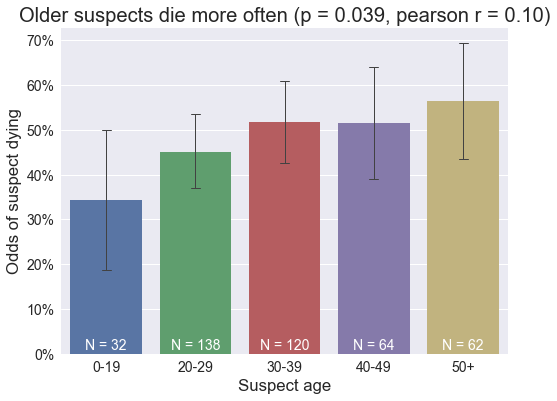

In [8]:
r, p = stats.pearsonr(age_present['target_age'], age_present['target_died'])

fig, ax = barplot_with_counts(shootings, 'target_age_cohort')
ax.set_title('Older suspects die more often ' + format_p(p, test_name='pearson r = %.2f' % r))
ax.set_xlabel('Suspect age')
pass

### Age of officer

In [9]:
def get_officer_age_cohort(age):
    if pd.isnull(age):
        return None
    elif age < 25:
        return "18-24"
    elif age >= 40:
        return "50+"
    else:
        age_bin = int(age / 5) * 5
        return "%d-%d" % (age_bin, age_bin + 4)

age_present = shootings.dropna(subset=['officer_age_1'])
print("%d incidents did not record suspect age" % (len(shootings) - len(age_present)))
age_present['officer_1_age_cohort'] = age_present['officer_age_1'].apply(get_officer_age_cohort)

0 incidents did not record suspect age


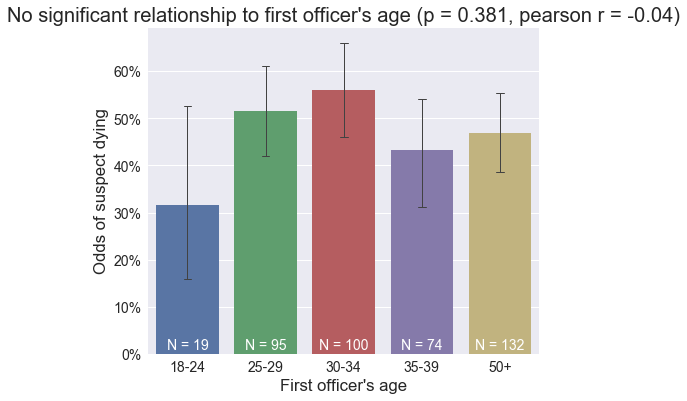

In [10]:
r, p = stats.pearsonr(age_present['officer_age_1'], age_present['target_died'])

fig, ax = barplot_with_counts(age_present, 'officer_1_age_cohort')
ax.set_title('No significant relationship to first officer\'s age ' + format_p(p, test_name='pearson r = %.2f' % r))
ax.set_xlabel('First officer\'s age')
pass

### Sex of suspect

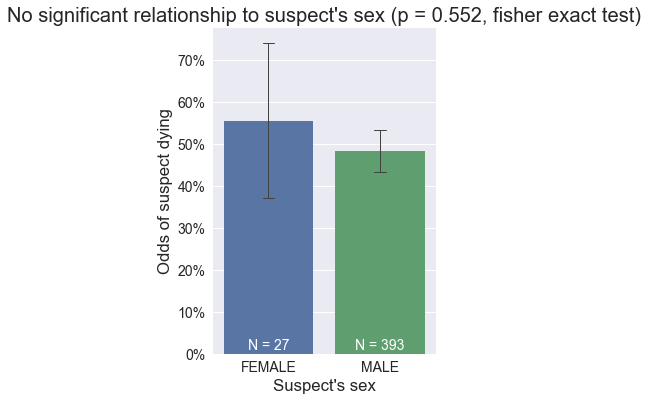

In [11]:
table = pd.crosstab(shootings['target_gender'], shootings['target_died'])
p = stats.fisher_exact(table)[1]

fig, ax = barplot_with_counts(shootings, 'target_gender')
ax.set_title("No significant relationship to suspect's sex " + format_p(p, 'fisher exact test'))
ax.set_xlabel("Suspect's sex")
pass

### Sex of officer

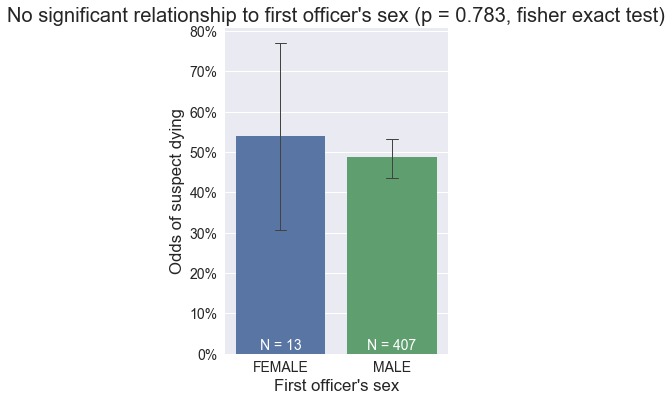

In [12]:
table = pd.crosstab(shootings['officer_gender_1'], shootings['target_died'])
p = stats.fisher_exact(table)[1]

fig, ax = barplot_with_counts(shootings, 'officer_gender_1')
ax.set_title("No significant relationship to first officer's sex " + format_p(p, 'fisher exact test'))
ax.set_xlabel("First officer's sex")
pass

### Race of suspect

In [13]:
shootings['target_race'].value_counts()

ANGLO OR WHITE                      161
HISPANIC OR LATINO                  137
BLACK OR AFRICAN AMERICAN           115
OTHER                                 3
ASIAN OR PACIFIC ISLANDER             3
AMERICAN INDIAN OR ALASKA NATIVE      1
Name: target_race, dtype: int64

#### Let's limit our analysis to the races with sufficient data

In [14]:
race_rename = {
    'ANGLO OR WHITE': 'WHITE',
    'HISPANIC OR LATINO': 'HISPANIC',
    'BLACK OR AFRICAN AMERICAN': 'BLACK',
}
shootings['target_race_limited'] = shootings['target_race'].apply(lambda r: race_rename.get(r, 'OTHER'))

for i in range(1, 11):
    shootings['officer_race_%d_limited' % i] = shootings['officer_race_%d' % i].apply(lambda r: None if pd.isnull(r) else race_rename.get(r, 'OTHER'))

shootings.target_race_limited.value_counts()

WHITE       161
HISPANIC    137
BLACK       115
OTHER         7
Name: target_race_limited, dtype: int64

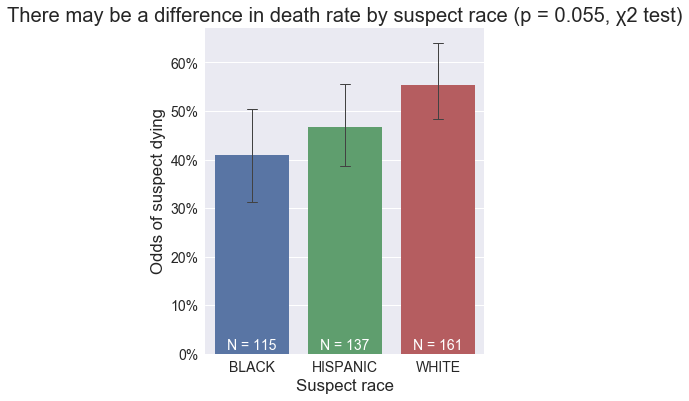

In [15]:
top3_races_suspect = shootings[shootings['target_race_limited'] != 'OTHER']

table = pd.crosstab(top3_races_suspect['target_race_limited'], top3_races_suspect['target_died'])
p = stats.chi2_contingency(table)[1]

fig, ax = barplot_with_counts(top3_races_suspect, 'target_race_limited')

ax.set_title("There may be a difference in death rate by suspect race " + format_p(p, 'χ2 test'))
ax.set_xlabel('Suspect race')
pass

### Race of first officer

In [16]:
shootings['officer_race_1_limited'].value_counts()

WHITE       265
HISPANIC    120
BLACK        32
OTHER         3
Name: officer_race_1_limited, dtype: int64

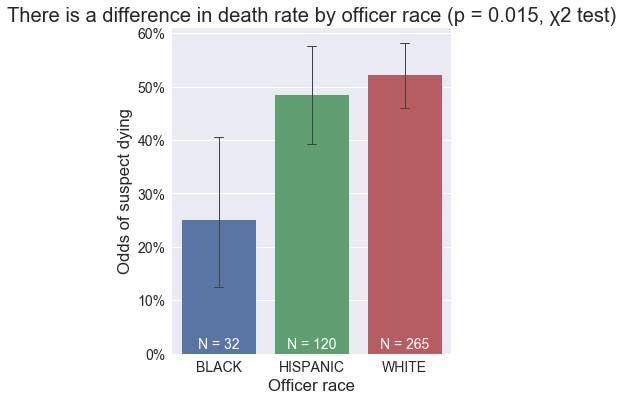

In [17]:
top3_races_officer = shootings[shootings['officer_race_1_limited'] != 'OTHER']

table = pd.crosstab(top3_races_officer['officer_race_1_limited'], top3_races_officer['target_died'])
p = stats.chi2_contingency(table)[1]

fig, ax = barplot_with_counts(top3_races_officer, 'officer_race_1_limited')

ax.set_title("There is a difference in death rate by officer race " + format_p(p, 'χ2 test'))
ax.set_xlabel('Officer race')
ax.set_ylabel('Odds of suspect dying')
pass

### Interaction of officer and suspect race

In [18]:
top3_races_both = shootings[(shootings['officer_race_1_limited'] != 'OTHER') &
                            (shootings['target_race_limited'] != 'OTHER')]
print("Ignoring %d of %d incidents where officer and suspect races were not both one of {white, black, or hispanic}" % (
    len(shootings) - len(top3_races_both), len(shootings)))
print()

Ignoring 10 of 420 incidents where officer and suspect races were not both one of {white, black, or hispanic}



In [19]:
counts = top3_races_both.groupby(['officer_race_1_limited', 'target_race_limited']).size().unstack()
p = stats.chi2_contingency(counts)[1]
print("Officer race and suspect race are not independent", format_p(p, 'χ2 test'))
counts

Officer race and suspect race are not independent (p < .001, χ2 test)


target_race_limited,BLACK,HISPANIC,WHITE
officer_race_1_limited,,,
BLACK,18,7,7
HISPANIC,25,61,33
WHITE,71,68,120


### White first-officers

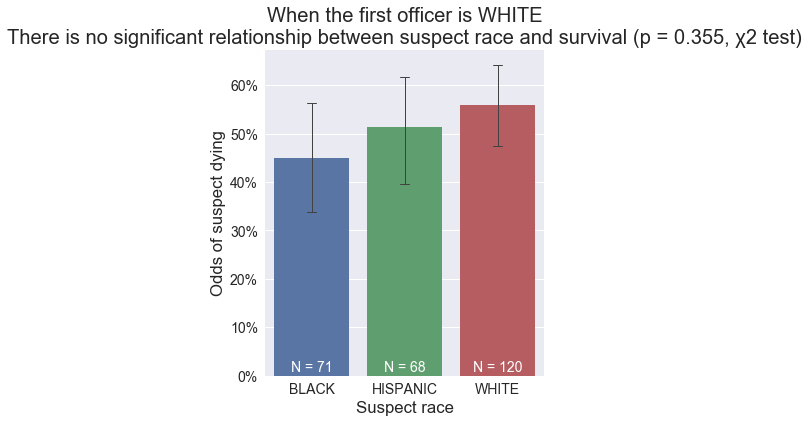

In [20]:
white_officer = top3_races_suspect[top3_races_suspect['officer_race_1_limited'] == 'WHITE']

table = pd.crosstab(white_officer['target_race_limited'], white_officer['target_died'])
p = stats.chi2_contingency(table)[1]

fig, ax = barplot_with_counts(white_officer, 'target_race_limited')

ax.set_title("When the first officer is WHITE\nThere is no significant relationship between suspect race and survival " + format_p(p, 'χ2 test'))
ax.set_xlabel('Suspect race')
ax.set_ylabel('Odds of suspect dying')
pass

### Hispanic first-officers

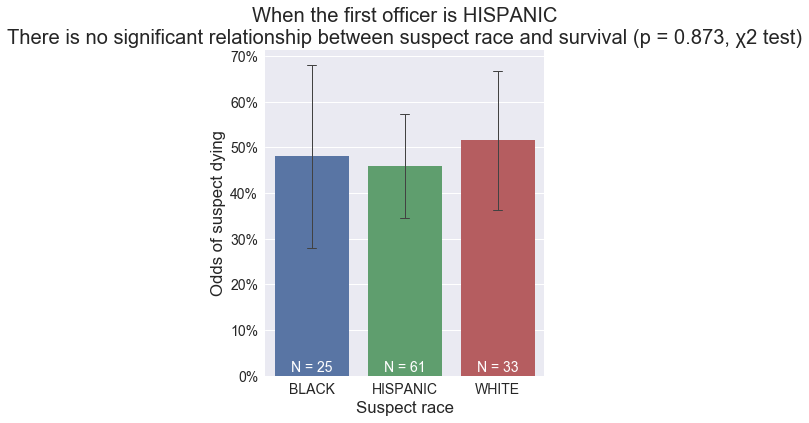

In [21]:
hispanic_officer = top3_races_suspect[top3_races_suspect['officer_race_1_limited'] == 'HISPANIC']

table = pd.crosstab(hispanic_officer['target_race_limited'], hispanic_officer['target_died'])
p = stats.chi2_contingency(table)[1]

fig, ax = barplot_with_counts(hispanic_officer, 'target_race_limited')

ax.set_title("When the first officer is HISPANIC\nThere is no significant relationship between suspect race and survival " + format_p(p, 'χ2 test'))
ax.set_xlabel('Suspect race')
ax.set_ylabel('Odds of suspect dying')
pass

### Black first-officers

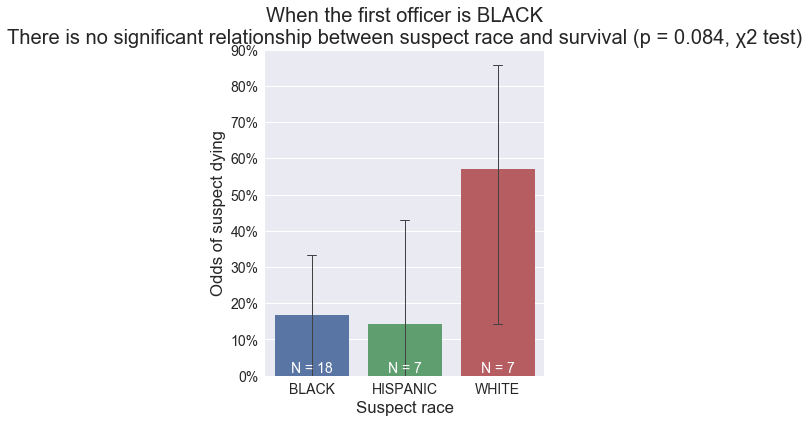

In [22]:
black_officer = top3_races_suspect[top3_races_suspect['officer_race_1_limited'] == 'BLACK']

table = pd.crosstab(black_officer['target_race_limited'], black_officer['target_died'])
p = stats.chi2_contingency(table)[1]

fig, ax = barplot_with_counts(black_officer, 'target_race_limited')

ax.set_title("When the first officer is BLACK\nThere is no significant relationship between suspect race and survival " + format_p(p, 'χ2 test'))
ax.set_xlabel('Suspect race')
ax.set_ylabel('Odds of suspect dying')
pass

### Number of officers recorded

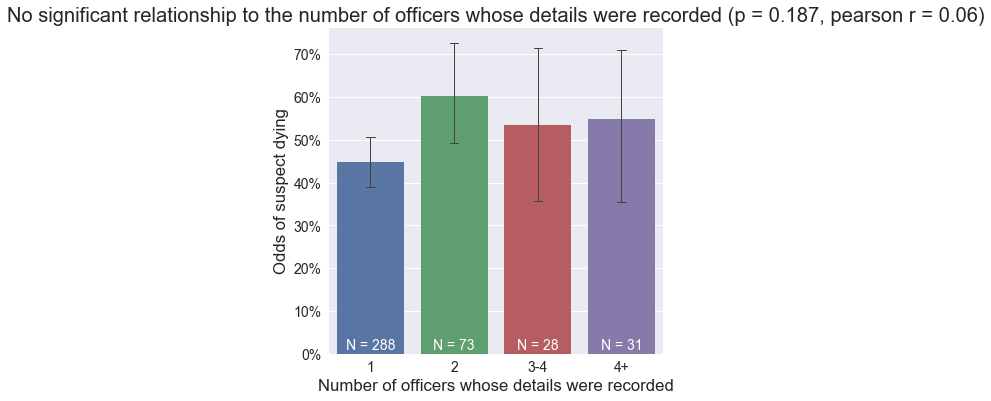

In [23]:
def get_num_officers_bucket(n):
    if n > 3:
        return "4+"
    elif n > 2:
        return "3-4"
    return str(n)

shootings['num_officers_recorded_bucket'] = shootings['num_officers_recorded'].apply(get_num_officers_bucket)

r, p = stats.pearsonr(shootings['num_officers_recorded'], shootings['target_died'])

fig, ax = barplot_with_counts(shootings, 'num_officers_recorded_bucket')
ax.set_title('No significant relationship to the number of officers whose details were recorded ' + format_p(p, test_name='pearson r = %.2f' % r))
ax.set_xlabel('Number of officers whose details were recorded')
pass

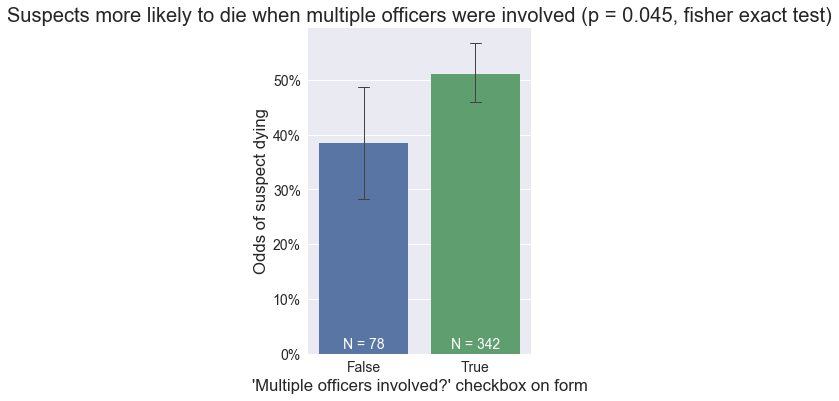

In [24]:
table = pd.crosstab(shootings['multiple_officers_involved'], shootings['target_died'])
p = stats.fisher_exact(table)[1]

fig, ax = barplot_with_counts(shootings, 'multiple_officers_involved')
ax.set_title("Suspects more likely to die when multiple officers were involved " + format_p(p, 'fisher exact test'))
ax.set_xlabel("'Multiple officers involved?' checkbox on form")
pass

### Reason for the encounter

In [25]:
shootings['incident_result_of'].value_counts()

EMERGENCY CALL OR REQUEST FOR ASSISTANCE                                                      170
OTHER - SPECIFY TYPE OF CALL                                                                  129
EXECUTION OF A WARRANT                                                                         39
TRAFFIC STOP                                                                                   38
HOSTAGE, BARRICADE, OR OTHER EMERGENCY SITUATION                                               34
EMERGENCY CALL OR REQUEST FOR ASSISTANCE, TRAFFIC STOP                                          4
EMERGENCY CALL OR REQUEST FOR ASSISTANCE; HOSTAGE, BARRICADE, OR OTHER EMERGENCY SITUATION      4
EMERGENCY                                                                                       2
Name: incident_result_of, dtype: int64

In [26]:
limited_reasons = {
    'EMERGENCY CALL OR REQUEST FOR ASSISTANCE': 'CALL',
    'EXECUTION OF A WARRANT': 'EXECUTING\nWARRANT',
    'TRAFFIC STOP': 'TRAFFIC\nSTOP'
}

In [27]:
shootings['incident_result_of_limited'] = shootings['incident_result_of'].apply(
    lambda r: limited_reasons.get(r, 'OTHER'))
shootings['incident_result_of_limited'].value_counts()

OTHER                 173
CALL                  170
EXECUTING\nWARRANT     39
TRAFFIC\nSTOP          38
Name: incident_result_of_limited, dtype: int64

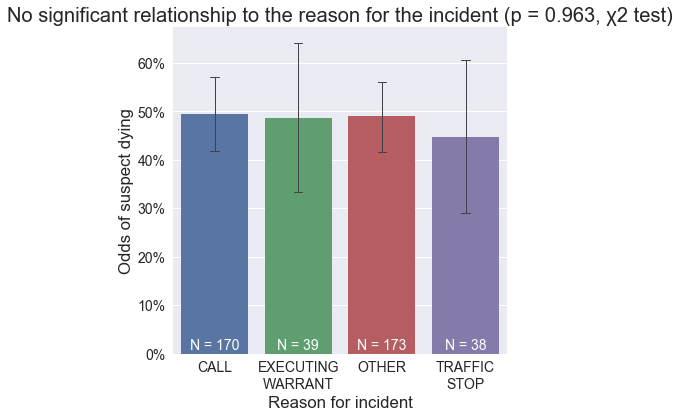

In [28]:
table = pd.crosstab(shootings['incident_result_of_limited'], shootings['target_died'])
p = stats.chi2_contingency(table)[1]

fig, ax = barplot_with_counts(shootings, 'incident_result_of_limited')

ax.set_title("No significant relationship to the reason for the incident " + format_p(p, 'χ2 test'))
ax.set_xlabel('Reason for incident')
ax.set_ylabel('Odds of suspect dying')
pass

### Suspect wielded deadly weapon

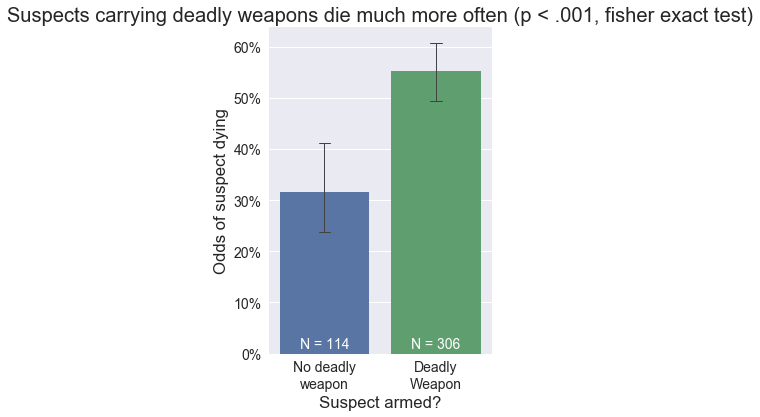

In [29]:
table = pd.crosstab(shootings['deadly_weapon'], shootings['target_died'])
p = stats.fisher_exact(table)[1]

fig, ax = barplot_with_counts(shootings, 'deadly_weapon')

ax.set_title("Suspects carrying deadly weapons die much more often " + format_p(p, test_name='fisher exact test'))
ax.set_xticklabels(['No deadly\nweapon', 'Deadly\nWeapon'])
ax.set_xlabel("Suspect armed?")
pass

### Type of deadly weapon

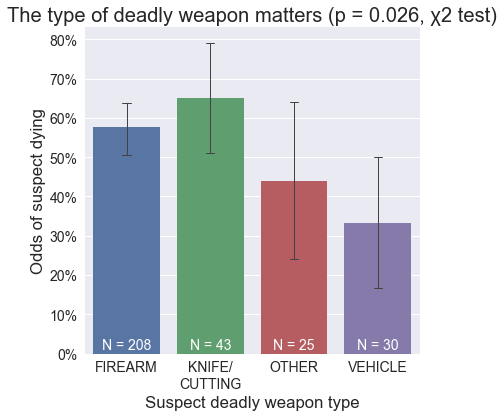

In [30]:
deadly_weapon = shootings[shootings['deadly_weapon']]
table = pd.crosstab(deadly_weapon['deadly_weapon_category'], shootings['target_died'])
p = stats.chi2_contingency(table)[1]

fig, ax = barplot_with_counts(deadly_weapon, 'deadly_weapon_category')

ax.set_title("The type of deadly weapon matters " + format_p(p, test_name='χ2 test'))
ax.set_xticklabels(['/\n'.join(t.get_text().split('/')) for t in ax.get_xticklabels()])
ax.set_xlabel("Suspect deadly weapon type")
pass

### Are all races equally likely to have a deadly weapon?

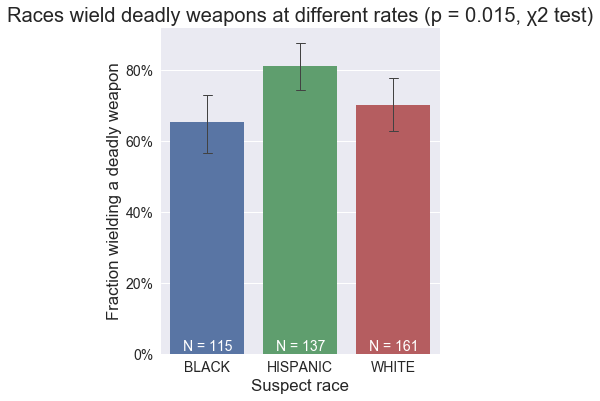

In [31]:
table = pd.crosstab(top3_races_suspect['target_race_limited'], top3_races_suspect['deadly_weapon'])
p = stats.chi2_contingency(table)[1]

fig, ax = barplot_with_counts(top3_races_suspect, 'target_race_limited', 'deadly_weapon')

ax.set_title("Races wield deadly weapons at different rates " + format_p(p, test_name='χ2 test'))
ax.set_ylabel("Fraction wielding a deadly weapon")
ax.set_xlabel("Suspect race")
pass

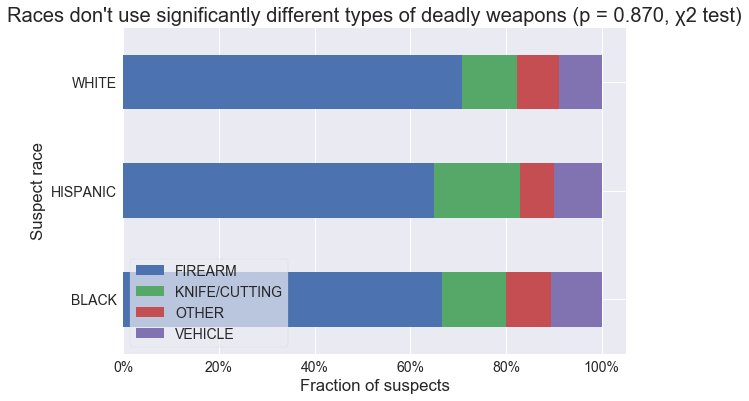

In [32]:
table = top3_races_suspect.groupby(['target_race_limited', 'deadly_weapon_category']).size().unstack()
p = stats.chi2_contingency(table)[1]

table = table.div(table.sum(axis=1), axis=0)

fig, ax = plt.subplots(1)
table.plot(kind='barh', stacked=True, ax=ax)
ax.legend(loc='lower left')
ax.set_ylabel('Suspect race')
ax.set_xlabel('Fraction of suspects')
eda.percentify_x(ax)
ax.set_title("Races don't use significantly different types of deadly weapons " + format_p(p, test_name='χ2 test'))
pass

### Time of day

In [33]:
has_time_of_day = shootings[shootings['time_incident'].notnull()]
print(f"Ignoring {len(shootings) - len(has_time_of_day)} of {len(shootings)} incidents that did not record a time of day")

Ignoring 141 of 420 incidents that did not record a time of day


/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


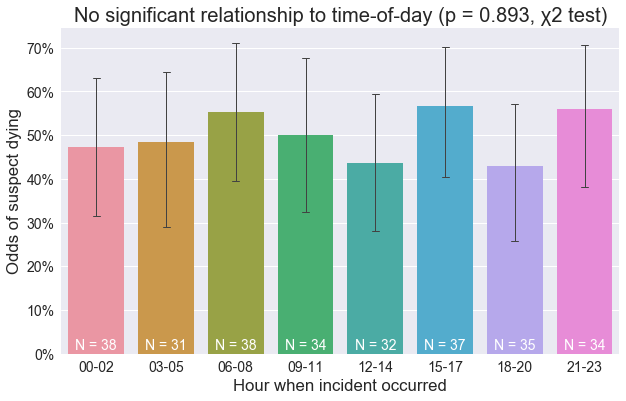

In [34]:
def get_time_of_day_bucket(t):
    bin_size = 3
    mod = 24 // bin_size
    r = int(t[:2]) % mod
    return "%02d-%02d" % (r * bin_size, (r + 1) * bin_size - 1)
    
has_time_of_day['time_of_day_bucket'] = has_time_of_day['time_incident'].apply(get_time_of_day_bucket)

table = pd.crosstab(has_time_of_day['time_of_day_bucket'], has_time_of_day['target_died'])
p = stats.chi2_contingency(table)[1]

fig, ax = barplot_with_counts(has_time_of_day, 'time_of_day_bucket')

ax.set_title("No significant relationship to time-of-day " + format_p(p, 'χ2 test'))
ax.set_xlabel('Hour when incident occurred')
pass

### Day of week

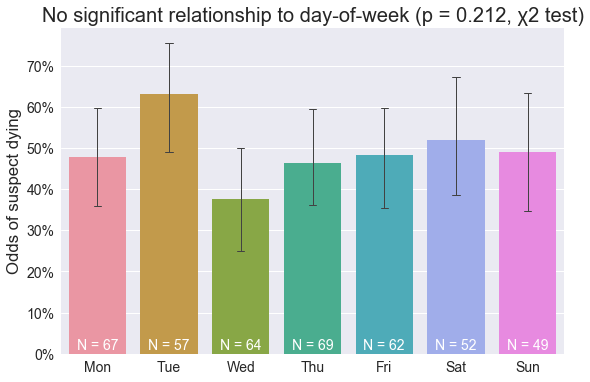

In [35]:
shootings['weekday'] = shootings['date_incident'].apply(lambda d: d.weekday())

table = pd.crosstab(shootings['weekday'], shootings['target_died'])
p = stats.chi2_contingency(table)[1]

fig, ax = barplot_with_counts(shootings, 'weekday')

ax.set_title("No significant relationship to day-of-week " + format_p(p, 'χ2 test'))
ax.set_xlabel('')
ax.set_xticklabels('Mon Tue Wed Thu Fri Sat Sun'.split())
pass

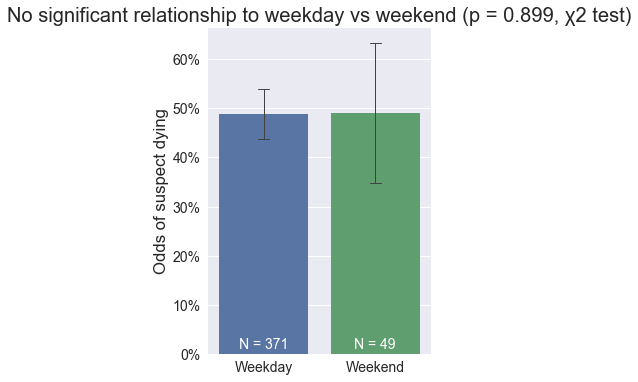

In [36]:
shootings['is_weekend'] = shootings['date_incident'].apply(lambda d: d.weekday() >= 6)

table = pd.crosstab(shootings['is_weekend'], shootings['target_died'])
p = stats.chi2_contingency(table)[1]

fig, ax = barplot_with_counts(shootings, 'is_weekend')

ax.set_title("No significant relationship to weekday vs weekend " + format_p(p, 'χ2 test'))
ax.set_xlabel('')
ax.set_xticklabels(['Weekday', 'Weekend'])
pass

### County size

In [37]:
print("Reading from data.world")
datasets = dw.load_dataset('tji/auxiliary-datasets', force_update=True)
census = datasets.dataframes['census_texas_counties']

Reading from data.world


In [38]:
county_populations = census[census['metric_description'] == 'Population estimates, July 1, 2016,  (V2016)'].iloc[0]
county_populations.drop(['metric_category', 'metric_subcategory', 'metric_description', 'all_texas'], inplace=True)
county_populations = county_populations.astype(int).to_dict()

In [39]:
def get_population_bin(p):
    if p >= 1e6:
        return '1MM+'
    elif p >= 1e5:
        return '100k-1MM'
    elif p >= 1e4:
        return '10k-100k'
    else:
        return '<10k'

In [40]:
shootings['incident_county_pop'] = shootings.incident_county.apply(
    lambda c: county_populations.get('_'.join(c.lower().split()), np.nan))
valid_counties = shootings.dropna(subset=['incident_county_pop'])
print("Ignoring %d incidents from unrecognized counties (likely bordering states)" % (
    len(shootings) - len(valid_counties)))
valid_counties['log_incident_county_pop'] = valid_counties['incident_county_pop'].apply(np.log10)
valid_counties['log_incident_county_pop_rounded'] = valid_counties['log_incident_county_pop'].astype(int)

Ignoring 2 incidents from unrecognized counties (likely bordering states)


/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


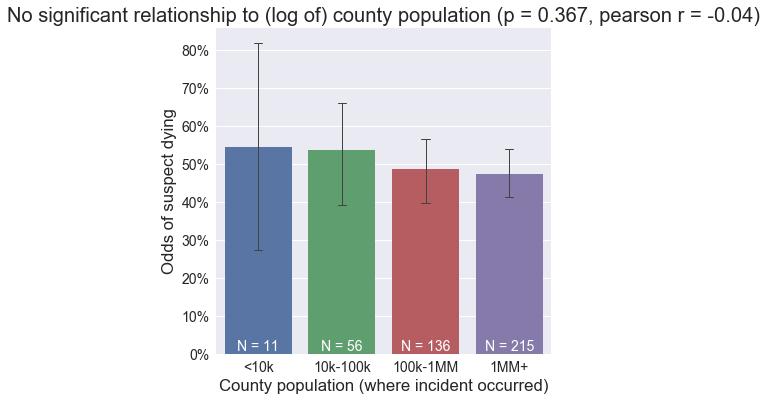

In [41]:
r, p = stats.pearsonr(valid_counties['log_incident_county_pop'], valid_counties['target_died'])

fig, ax = barplot_with_counts(valid_counties, 'log_incident_county_pop_rounded')
ax.set_title('No significant relationship to (log of) county population ' + format_p(p, test_name='pearson r = %.2f' % r))
ax.set_xlabel('County population (where incident occurred)')
ax.set_xticklabels(['<10k', '10k-100k', '100k-1MM', '1MM+'])
pass